Original GT first position: [4.000, -0.060, 1.800]
Transformed GT first position: [0.000, 0.000, 0.000]


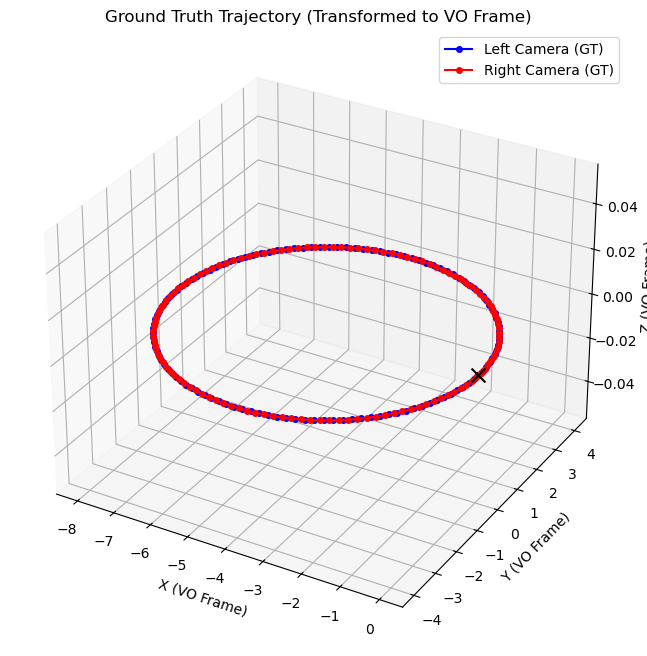


Ground Truth in VO coordinate frame:
  Trajectory center: [-3.967, 0.060, 0.000]
  X range: -8.000 to 0.000
  Y range: -3.940 to 4.060
  Z range: 0.000 to 0.000
  Circle radius: 4.000 m
  Saved transformed GT to 'gt_in_vo_frame.json'


In [2]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2



# Simple ground truth visualization transformed to VO coordinate frame

import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the ground truth data
with open('maximum_feature_office_dataset/ground_truth_poses.json', 'r') as file:
    ground_truth = json.load(file)

# Extract pose data
poses = ground_truth['poses']

# Extract left camera positions (we'll use left camera as reference)
left_positions = []
for pose in poses:
    left_trans = pose['left_camera']['translation']
    left_positions.append([left_trans[0], left_trans[1], left_trans[2]])

left_positions = np.array(left_positions)

# Transform to VO coordinate frame (first frame becomes origin)
first_position = left_positions[0].copy()
gt_transformed = left_positions - first_position

print(f"Original GT first position: [{first_position[0]:.3f}, {first_position[1]:.3f}, {first_position[2]:.3f}]")
print(f"Transformed GT first position: [{gt_transformed[0][0]:.3f}, {gt_transformed[0][1]:.3f}, {gt_transformed[0][2]:.3f}]")

# Separate coordinates for plotting
left_x = gt_transformed[:, 0]
left_y = gt_transformed[:, 1] 
left_z = gt_transformed[:, 2]

# Do the same for right camera if needed
right_positions = []
for pose in poses:
    right_trans = pose['right_camera']['translation']
    right_positions.append([right_trans[0], right_trans[1], right_trans[2]])

right_positions = np.array(right_positions)
right_transformed = right_positions - first_position  # Same offset as left

right_x = right_transformed[:, 0]
right_y = right_transformed[:, 1]
right_z = right_transformed[:, 2]

# 3D plot in VO coordinate frame
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(left_x, left_y, left_z, 'b-o', label='Left Camera (GT)', markersize=4)
ax.plot(right_x, right_y, right_z, 'r-o', label='Right Camera (GT)', markersize=4)

ax.set_xlabel('X (VO Frame)')
ax.set_ylabel('Y (VO Frame)')
ax.set_zlabel('Z (VO Frame)')
ax.set_title('Ground Truth Trajectory (Transformed to VO Frame)')
ax.legend()

# Mark origin (first frame)
ax.scatter([0], [0], [0], color='black', s=100, marker='x', label='VO Origin (Frame 1)')

plt.show()

# Print some statistics in VO frame
print(f"\nGround Truth in VO coordinate frame:")
print(f"  Trajectory center: [{np.mean(left_x):.3f}, {np.mean(left_y):.3f}, {np.mean(left_z):.3f}]")
print(f"  X range: {np.min(left_x):.3f} to {np.max(left_x):.3f}")
print(f"  Y range: {np.min(left_y):.3f} to {np.max(left_y):.3f}")  
print(f"  Z range: {np.min(left_z):.3f} to {np.max(left_z):.3f}")

# Calculate circle radius from center
circle_center = np.array([np.mean(left_x), np.mean(left_y)])
distances = np.sqrt((left_x - circle_center[0])**2 + (left_y - circle_center[1])**2)
radius = np.mean(distances)
print(f"  Circle radius: {radius:.3f} m")

# Save transformed GT for easy comparison later
gt_for_comparison = {
    'positions': gt_transformed.tolist(),
    'radius': float(radius),
    'center': [float(np.mean(left_x)), float(np.mean(left_y)), float(np.mean(left_z))]
}

with open('maximum_feature_office_dataset/gt_in_vo_frame.json', 'w') as f:
    json.dump(gt_for_comparison, f, indent=2)

print(f"  Saved transformed GT to 'gt_in_vo_frame.json'")

In [ ]:
import cv2 
import numpy as np
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.color import rgb2hsv, hsv2rgb
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
import cv2



class SIFT:
    def __init__(self, n_features=500):
        self.n_features = n_features
        self.sift = cv2.SIFT_create(nfeatures=self.n_features)
    

    def detect_and_compute(self, image, mask=None):
        """Detect keypoints and compute descriptors."""
        gray_image = convert_to_grayscale(image)
        keypoints, descriptors = self.sift.detectAndCompute(gray_image, mask)

        keypoints_location = np.array([kp.pt for kp in keypoints])
        

        return keypoints, descriptors, keypoints_location
    
    def match_features(self, descriptors1, descriptors2):
        """Match features between two sets of descriptors using Lowe's ratio test."""
        if descriptors1 is None or descriptors2 is None:
            return []

        
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)

        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)


        query_idx = [m.queryIdx for m in good_matches]
        train_idx = [m.trainIdx for m in good_matches]

        return good_matches, query_idx, train_idx
    
def convert_to_grayscale(image):
    if image.ndim == 3:  
        return (0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]).astype(np.uint8)
    else:
        return image




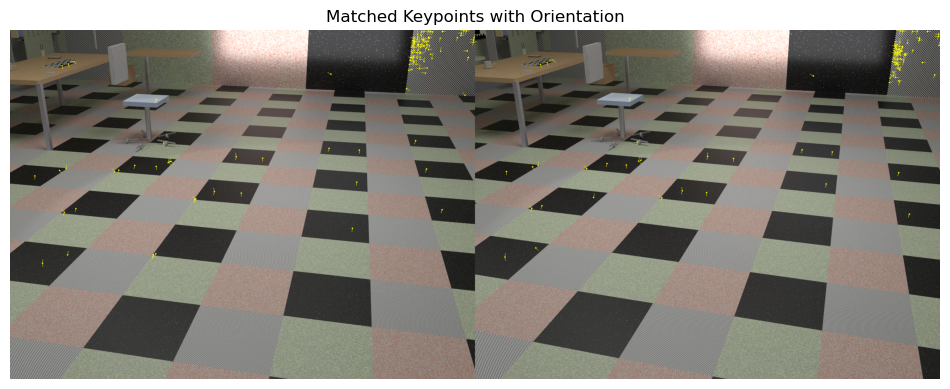

In [9]:
semper1 = cv2.imread('/tmp/maximum_feature_office_dataset/left/frame_0005.png', cv2.IMREAD_COLOR)
semper2 = cv2.imread('/tmp/maximum_feature_office_dataset/left/frame_0006.png', cv2.IMREAD_COLOR)

# Convert to RGB
semper1 = cv2.cvtColor(semper1, cv2.COLOR_BGR2RGB)
semper2 = cv2.cvtColor(semper2, cv2.COLOR_BGR2RGB)

sift_semper = SIFT(n_features=1500)
keypoints1, descriptors1, keypoints_location1 = sift_semper.detect_and_compute(semper1)
keypoints2, descriptors2, keypoints_location2 = sift_semper.detect_and_compute(semper2)

if descriptors1 is None or descriptors2 is None:
    raise ValueError("SIFT descriptors could not be computed. Ensure the images are valid and contain features.")
good_matches, query_idx, train_idx = sift_semper.match_features(descriptors1, descriptors2)

good_matches_location1 = np.array([keypoints_location1[m.queryIdx] for m in good_matches])
good_matches_location2 = np.array([keypoints_location2[m.trainIdx] for m in good_matches])



h1, w1 = semper1.shape[:2]
h2, w2 = semper2.shape[:2]
out_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
out_img[:h1, :w1] = semper1
out_img[:h2, w1:] = semper2


color = (255, 255, 0)  # Yellow (BGR)
radius = 2
line_length = 10
thickness = 1


for match in good_matches:
    # Image 1 keypoint
    kp1 = keypoints1[match.queryIdx]
    pt1 = tuple(np.round(kp1.pt).astype(int))
    angle1 = math.radians(kp1.angle)
    end1 = (
        int(pt1[0] + line_length * math.cos(angle1)),
        int(pt1[1] + line_length * math.sin(angle1))
    )

    # Image 2 keypoint 
    kp2 = keypoints2[match.trainIdx]
    pt2 = tuple(np.round(kp2.pt).astype(int))
    pt2_shifted = (pt2[0] + w1, pt2[1])
    angle2 = math.radians(kp2.angle)
    end2 = (
        int(pt2_shifted[0] + line_length * math.cos(angle2)),
        int(pt2_shifted[1] + line_length * math.sin(angle2))
    )

    
    cv2.circle(out_img, pt1, radius, color, -1)
    cv2.line(out_img, pt1, end1, color, thickness)

    cv2.circle(out_img, pt2_shifted, radius, color, -1)
    cv2.line(out_img, pt2_shifted, end2, color, thickness)


plt.figure(figsize=(12, 6))
plt.imshow(out_img)
plt.axis('off')
plt.title('Matched Keypoints with Orientation')
plt.show()



